# Human Gait Database: Gait Analysis

# Table of Contents
 
- [Import library and define visualization parameters](#Import-library-and-define-visualization-parameters)
- [Declaration of functions used](#Declaration-of-functions-used)
- [Import data](#Import-data)
- [Display and summarize datasets](#Display-and-summarize-datasets)
- [Data exploration and visualization](#Data-exploration-and-visualization)
- [Feature engineering](#Feature-engineering)
- [Classical Machine Learning Models](#Classical-Machine-Learning-Models)
    - [Data Visualization](#Data-Visualization)
    - [Logistic Regression Classifier](#Logistic-Regression-Classifier)
    - [Decision Tree Classifier](#Decision-Tree-Classifier)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    - [KNN Classifier](#KNN-Classifier)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [LightGBM Classifier](#LightGBM-Classifier)
    - [XGBoost Classifier](#XGBoost-Classifier)
    - [Artificial Neural Network](#Artificial-Neural-Network)
    - [ML Models Accuracy Validation Comparison](#ML-Models-Accuracy-Validation-Comparison)

# Import library and define visualization parameters

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import glob
from IPython.display import display, HTML

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

import warnings 
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\niang\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
# Define certain standard parameters at the outset
pd.options.display.float_format = '{: .1f}'. format
np.set_printoptions(precision=2)
sns.set () # Default marine appearance
plt.style.use ('ggplot')
# Files
path_to_file = '../data_1'
all_files = glob.glob(path_to_file + "/*.txt")

# Declaration of functions used

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [4]:
# Define a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    plt.figure(figsize=(15,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [6]:
def plot_learning_curves(estimator, X_train, y_train, X_val, y_val,
                         suptitle='', title='', xlabel='training set size', ylabel='accuracy'):
    """
    Plots learning curves for a given estimator.
    Parameters
    ----------
    estimator : sklearn estimator
    X_train : pd.DataFrame
        training set (features)
    y_train : pd.Series
        training set (response)
    X_val : pd.DataFrame
        validation set (features)
    y_val : pd.Series
        validation set (response)
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(5, len(X_train), 10, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        # fit the model only using that many training examples
        estimator.fit(X_train.iloc[0:i, :], y_train.iloc[0:i])
        # calculate the training accuracy only using those training examples
        train_accuracy = metrics.accuracy_score(
                                    y_train.iloc[0:i],
                                    estimator.predict(X_train.iloc[0:i, :])
                                    )
        # calculate the validation accuracy using the whole validation set
        val_accuracy = metrics.accuracy_score(
                                    y_val,
                                    estimator.predict(X_val)
                                    )
        # store the scores in their respective lists
        train_score.append(train_accuracy)
        val_score.append(val_accuracy)
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training set', 'validation set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = FuncFormatter(percentages)
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = FuncFormatter(numbers)
    ax.xaxis.set_major_formatter(x_formatter)

# Import data

In [7]:
li = []
colnames = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y', 'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x', 'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z', 'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y', 'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x', 'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z', 'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y', 'gyro_lt_z', 'EMG_r', 'EMG_l', 'act'] 
for filename in all_files:
    df = pd.read_csv(filename, delimiter='\t', names=colnames, skiprows=4, )
    filename = filename.split('\\')[-1]
    df['filename'] = filename
    li.append(df)

hugadb = pd.concat(li, axis=0, ignore_index=True)

# Display and summarize datasets

In [8]:
hugadb = hugadb[['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y', 'gyro_rf_z', 'act', 'filename']]
hugadb

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,act,filename
0,-14392,-96,10628,138,-388,492,9,HuGaDB_v1_bicycling_01_00.txt
1,-11248,164,7744,169,699,429,9,HuGaDB_v1_bicycling_01_00.txt
2,-15892,-1952,9324,-217,709,360,9,HuGaDB_v1_bicycling_01_00.txt
3,-13020,892,8604,-297,-62,170,9,HuGaDB_v1_bicycling_01_00.txt
4,-12780,-948,10744,-301,-1359,39,9,HuGaDB_v1_bicycling_01_00.txt
...,...,...,...,...,...,...,...,...
2111864,-10924,-11324,13852,8474,-32768,-24184,1,HuGaDB_v1_walking_18_03.txt
2111865,-15948,-15856,20460,9858,-32768,-25804,1,HuGaDB_v1_walking_18_03.txt
2111866,-22368,-20200,26024,13920,-32768,-27287,1,HuGaDB_v1_walking_18_03.txt
2111867,-26892,-25644,27144,17215,-32768,-28774,1,HuGaDB_v1_walking_18_03.txt


In [9]:
hugadb.describe()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,act
count,2111869.0,2111869.0,2111869.0,2111869.0,2111869.0,2111869.0,2111869.0
mean,-11088.8,-5221.2,11729.0,-292.5,-203.3,-197.6,5.2
std,9137.8,8290.7,9045.5,5254.8,11129.8,8481.9,3.8
min,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,1.0
25%,-11708.0,-7932.0,11116.0,-230.0,-76.0,-209.0,1.0
50%,-9204.0,-4632.0,12748.0,-12.0,23.0,-28.0,5.0
75%,-7228.0,-2736.0,14076.0,177.0,626.0,543.0,8.0
max,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,12.0


In [10]:
hugadb.isna().sum()

acc_rf_x     0
acc_rf_y     0
acc_rf_z     0
gyro_rf_x    0
gyro_rf_y    0
gyro_rf_z    0
act          0
filename     0
dtype: int64

In [11]:
hugadb.dtypes

acc_rf_x      int64
acc_rf_y      int64
acc_rf_z      int64
gyro_rf_x     int64
gyro_rf_y     int64
gyro_rf_z     int64
act           int64
filename     object
dtype: object

In [12]:
hugadb['act'] = hugadb['act'].astype('category')
hugadb.act.sum

<bound method Series.sum of 0          9
1          9
2          9
3          9
4          9
          ..
2111864    1
2111865    1
2111866    1
2111867    1
2111868    1
Name: act, Length: 2111869, dtype: category
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]>

In [13]:
hugadb.astype('object').describe()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,act,filename
count,2111869,2111869,2111869,2111869,2111869,2111869,2111869,2111869
unique,15552,16370,16358,55496,64984,64476,12,635
top,-32768,-32768,32767,-12,-32768,-24,1,HuGaDB_v1_sitting_in_car_01_05.txt
freq,171477,42883,38387,23339,73485,28795,679073,21155


In [14]:
# Create the dictionary 
event_dictionary = {1 : 'Walking', 2 : 'Running', 3 : 'Going up', 4 : 'Going down', 5 : 'Sitting', 6 : 'Sitting down', 7 : 'Standing up', 8 : 'Standing', 9 : 'Bicycling', 10 : 'Up by elevator', 11 : 'Down by elevator', 12 : 'Sitting in car'} 

# Add a new column named 'Price' 
hugadb['activity'] = hugadb['act'].apply(set_value, args =(event_dictionary, ))

# Print the DataFrame 
hugadb

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,act,filename,activity
0,-14392,-96,10628,138,-388,492,9,HuGaDB_v1_bicycling_01_00.txt,Bicycling
1,-11248,164,7744,169,699,429,9,HuGaDB_v1_bicycling_01_00.txt,Bicycling
2,-15892,-1952,9324,-217,709,360,9,HuGaDB_v1_bicycling_01_00.txt,Bicycling
3,-13020,892,8604,-297,-62,170,9,HuGaDB_v1_bicycling_01_00.txt,Bicycling
4,-12780,-948,10744,-301,-1359,39,9,HuGaDB_v1_bicycling_01_00.txt,Bicycling
...,...,...,...,...,...,...,...,...,...
2111864,-10924,-11324,13852,8474,-32768,-24184,1,HuGaDB_v1_walking_18_03.txt,Walking
2111865,-15948,-15856,20460,9858,-32768,-25804,1,HuGaDB_v1_walking_18_03.txt,Walking
2111866,-22368,-20200,26024,13920,-32768,-27287,1,HuGaDB_v1_walking_18_03.txt,Walking
2111867,-26892,-25644,27144,17215,-32768,-28774,1,HuGaDB_v1_walking_18_03.txt,Walking


# Data exploration and visualization

Text(0, 0.5, 'Percentage')

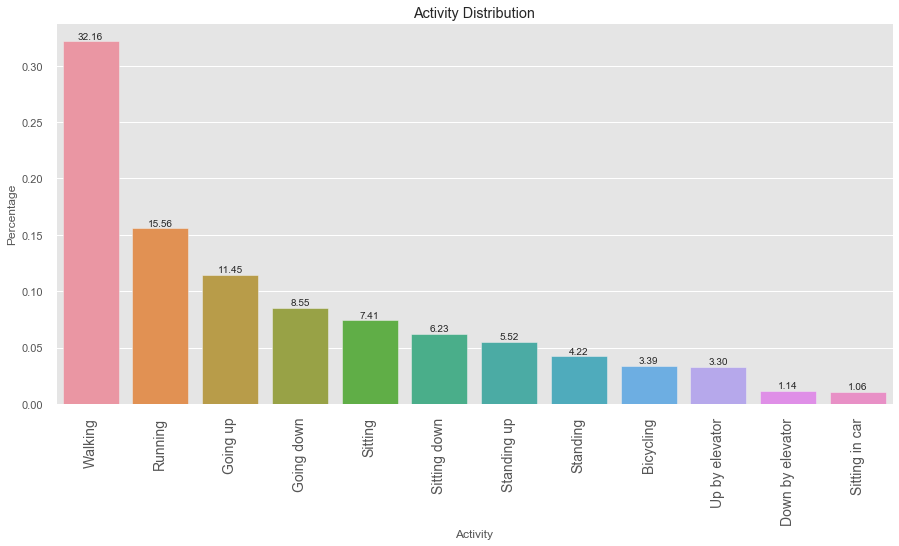

In [15]:
plt.figure(figsize=(15,7))
yaxis = hugadb['activity'].value_counts().values / hugadb.shape[0]
labels = ['Walking', 'Running', 'Going up', 'Going down', 'Sitting', 'Sitting down', 'Standing up', 'Standing', 'Bicycling', 'Up by elevator', 'Down by elevator', 'Sitting in car']
barplot = sns.barplot(x = labels, y=yaxis)
for p in barplot.patches:
    barplot.annotate(format(p.get_height()*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.xticks(fontsize=14)
plt.xticks(rotation='vertical')
plt.title("Activity Distribution")
plt.xlabel('Activity')
plt.ylabel('Percentage')

# Feature engineering

In [19]:
hugadb = hugadb[['act', 'activity', 'filename', 'acc_rf_x', 'acc_rf_y', 'acc_rf_z']]
hugadb['acc_norm'] = np.sqrt((hugadb.acc_rf_x)**2 + (hugadb.acc_rf_y)**2 + (hugadb.acc_rf_z)**2)
hugadb

,act,activity,filename,acc_rf_x,acc_rf_y,acc_rf_z,acc_norm
0,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-14392,-96,10628,17891.2
1,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-11248,164,7744,13657.0
2,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-15892,-1952,9324,18528.4
3,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-13020,892,8604,15631.5
4,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-12780,-948,10744,16723.1
...,...,...,...,...,...,...,...
2111864,1,Walking,HuGaDB_v1_walking_18_03.txt,-10924,-11324,13852,20962.9
2111865,1,Walking,HuGaDB_v1_walking_18_03.txt,-15948,-15856,20460,30403.3
2111866,1,Walking,HuGaDB_v1_walking_18_03.txt,-22368,-20200,26024,39819.8
2111867,1,Walking,HuGaDB_v1_walking_18_03.txt,-26892,-25644,27144,46017.3


In [20]:
679073/11544*3

176.47427234927235

In [21]:
71653/1218*3

176.48522167487687

In [22]:
131604/2237*3

176.4917299955297

In [23]:
toast = hugadb.index.tolist()
toast

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [24]:
sample_size = 176
ind_trois = np.cumsum([(el % sample_size) == 0 for el in toast]).tolist()
ind_trois

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [25]:
ind_trois.count(3)

176

In [26]:
hugadb['ind_trois'] = ind_trois
hugadb

,act,activity,filename,acc_rf_x,acc_rf_y,acc_rf_z,acc_norm,ind_trois
0,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-14392,-96,10628,17891.2,1
1,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-11248,164,7744,13657.0,1
2,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-15892,-1952,9324,18528.4,1
3,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-13020,892,8604,15631.5,1
4,9,Bicycling,HuGaDB_v1_bicycling_01_00.txt,-12780,-948,10744,16723.1,1
...,...,...,...,...,...,...,...,...
2111864,1,Walking,HuGaDB_v1_walking_18_03.txt,-10924,-11324,13852,20962.9,12000
2111865,1,Walking,HuGaDB_v1_walking_18_03.txt,-15948,-15856,20460,30403.3,12000
2111866,1,Walking,HuGaDB_v1_walking_18_03.txt,-22368,-20200,26024,39819.8,12000
2111867,1,Walking,HuGaDB_v1_walking_18_03.txt,-26892,-25644,27144,46017.3,12000


In [27]:
hugadb.dtypes

act          category
activity     category
filename       object
acc_rf_x        int64
acc_rf_y        int64
acc_rf_z        int64
acc_norm      float64
ind_trois       int64
dtype: object

In [28]:
hugadb = hugadb.astype({"act": np.int64})

In [29]:
hugadb.dtypes

act             int64
activity     category
filename       object
acc_rf_x        int64
acc_rf_y        int64
acc_rf_z        int64
acc_norm      float64
ind_trois       int64
dtype: object

In [30]:
grouped_hugadb = hugadb.groupby(['act','ind_trois', 'filename']).agg(
            acc_rf_x_min = ('acc_rf_x', 'min'),
            acc_rf_x_max = ('acc_rf_x', 'max'),
            acc_rf_x_mean = ('acc_rf_x', 'mean'),
            acc_rf_x_std = ('acc_rf_x', lambda x: x.std()),
            acc_rf_x_range = ('acc_rf_x', lambda x: x.max() - x.min()),
            acc_rf_y_min = ('acc_rf_y', 'min'),
            acc_rf_y_max = ('acc_rf_y', 'max'),
            acc_rf_y_mean = ('acc_rf_y', 'mean'),
            acc_rf_y_std = ('acc_rf_y', lambda x: x.std()),
            acc_rf_y_range = ('acc_rf_y', lambda x: x.max() - x.min()),
            acc_rf_z_min = ('acc_rf_z', 'min'),
            acc_rf_z_max = ('acc_rf_z', 'max'),
            acc_rf_z_mean = ('acc_rf_z', 'mean'),
            acc_rf_z_std = ('acc_rf_z', lambda x: x.std()),
            acc_rf_z_range = ('acc_rf_z', lambda x: x.max() - x.min()),
            acc_norm_min = ('acc_norm', 'min'),
            acc_norm_max = ('acc_norm', 'max'),
            acc_norm_mean = ('acc_norm', 'mean'),
            acc_norm_std = ('acc_norm', lambda x: x.std()),
            acc_norm_range = ('acc_norm', lambda x: x.max() - x.min())
)
grouped_hugadb

acc_rf_x_min  acc_rf_x_max  \
act ind_trois filename                                                         
1   3529      HuGaDB_v1_various_01_04.txt               -32768         15656   
    3530      HuGaDB_v1_various_01_04.txt               -32768         11160   
    3531      HuGaDB_v1_various_01_04.txt               -10028         -4944   
    3532      HuGaDB_v1_various_01_04.txt               -32768         25412   
    3533      HuGaDB_v1_various_01_04.txt               -32768         11792   
...                                                        ...           ...   
12  2908      HuGaDB_v1_sitting_in_car_01_14.txt         -4096           -40   
    2909      HuGaDB_v1_sitting_in_car_01_14.txt         -4020         -1728   
    2910      HuGaDB_v1_sitting_in_car_01_14.txt         -3284         -1744   
    2911      HuGaDB_v1_sitting_in_car_01_14.txt         -2464           264   
    2912      HuGaDB_v1_sitting_in_car_01_14.txt          -720          -440   

                                                  acc_rf_x_mean  acc_rf_x_std  \
act ind_trois filename                                                          
1   3529      HuGaDB_v1_various_01_04.txt              -15436.7       11323.9   
    3530      HuGaDB_v1_various_01_04.txt              -11995.5       10121.5   
    3531      HuGaDB_v1_various_01_04.txt               -7105.3        2626.1   
    3532      HuGaDB_v1_various_01_04.txt              -13151.7       12640.0   
    3533      HuGaDB_v1_various_01_04.txt              -13703.6       11865.8   
...                                                         ...           ...   
12  2908      HuGaDB_v1_sitting_in_car_01_14.txt        -2556.5         823.7   
    2909      HuGaDB_v1_sitting_in_car_01_14.txt        -2878.0         460.2   
    2910      HuGaDB_v1_sitting_in_car_01_14.txt        -2649.4         325.5   
    2911      HuGaDB_v1_sitting_in_car_01_14.txt        -1345.1         594.6   
    2912      HuGaDB_v1_sitting_in_car_01_14.txt         -563.8          56.0   

                                                  acc_rf_x_range  \
act ind_trois filename                                             
1   3529      HuGaDB_v1_various_01_04.txt                  48424   
    3530      HuGaDB_v1_various_01_04.txt                  43928   
    3531      HuGaDB_v1_various_01_04.txt                   5084   
    3532      HuGaDB_v1_various_01_04.txt                  58180   
    3533      HuGaDB_v1_various_01_04.txt                  44560   
...                                                          ...   
12  2908      HuGaDB_v1_sitting_in_car_01_14.txt            4056   
    2909      HuGaDB_v1_sitting_in_car_01_14.txt            2292   
    2910      HuGaDB_v1_sitting_in_car_01_14.txt            1540   
    2911      HuGaDB_v1_sitting_in_car_01_14.txt            2728   
    2912      HuGaDB_v1_sitting_in_car_01_14.txt             280   

                                                  acc_rf_y_min  acc_rf_y_max  \
act ind_trois filename                                                         
1   3529      HuGaDB_v1_various_01_04.txt               -27832         19024   
    3530      HuGaDB_v1_various_01_04.txt               -29140         20056   
    3531      HuGaDB_v1_various_01_04.txt                -5624         -4088   
    3532      HuGaDB_v1_various_01_04.txt               -32768         32767   
    3533      HuGaDB_v1_various_01_04.txt               -32768         19616   
...                                                        ...           ...   
12  2908      HuGaDB_v1_sitting_in_car_01_14.txt        -12120         -7040   
    2909      HuGaDB_v1_sitting_in_car_01_14.txt        -12080         -7576   
    2910      HuGaDB_v1_sitting_in_car_01_14.txt        -11000         -9088   
    2911      HuGaDB_v1_sitting_in_car_01_14.txt        -10712         -9320   
    2912      HuGaDB_v1_sitting_in_car_01_14.txt        -10640         -9716   

                             

In [31]:
grouped_hugadb = grouped_hugadb.reset_index()

In [32]:
del grouped_hugadb['ind_trois']
del grouped_hugadb['filename']

In [34]:
# Create the dictionary 
event_dictionary = {1 : 'Walking', 2 : 'Running', 3 : 'Going up', 4 : 'Going down', 5 : 'Sitting', 6 : 'Sitting down', 7 : 'Standing up', 8 : 'Standing', 9 : 'Bicycling', 10 : 'Up by elevator', 11 : 'Down by elevator', 12 : 'Sitting in car'} 

# Add a new column named 'Price' 
grouped_hugadb['activity'] = grouped_hugadb['act'].apply(set_value, args =(event_dictionary, ))

# Print the DataFrame 
grouped_hugadb

,act,acc_rf_x_min,acc_rf_x_max,acc_rf_x_mean,acc_rf_x_std,acc_rf_x_range,acc_rf_y_min,acc_rf_y_max,acc_rf_y_mean,acc_rf_y_std,...,acc_rf_z_max,acc_rf_z_mean,acc_rf_z_std,acc_rf_z_range,acc_norm_min,acc_norm_max,acc_norm_mean,acc_norm_std,acc_norm_range,activity
0,1,-32768,15656,-15436.7,11323.9,48424,-27832,19024,-2951.4,9017.1,...,32767,13153.1,11307.1,65535,16009.9,51644.4,26088.6,8527.0,35634.5,Walking
1,1,-32768,11160,-11995.5,10121.5,43928,-29140,20056,-4461.0,6273.2,...,32767,14315.4,7175.0,43575,11183.2,45744.6,22544.9,7250.6,34561.4,Walking
2,1,-10028,-4944,-7105.3,2626.1,5084,-5624,-4088,-4816.0,771.1,...,23588,20789.3,2957.0,5892,20746.6,24881.1,22667.3,2082.8,4134.5,Walking
3,1,-32768,25412,-13151.7,12640.0,58180,-32768,32767,-10325.1,9923.5,...,32767,14107.4,9489.8,54919,14937.9,56125.1,26768.4,10439.8,41187.2,Walking
4,1,-32768,11792,-13703.6,11865.8,44560,-32768,19616,-8637.5,9849.0,...,32767,13267.6,9903.3,50895,13689.9,56755.3,25869.2,10186.5,43065.4,Walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16009,12,-4096,-40,-2556.5,823.7,4056,-12120,-7040,-9669.4,898.4,...,15024,13438.5,564.7,2880,15301.3,18387.3,16792.1,669.3,3086.1,Sitting in car
16010,12,-4020,-1728,-2878.0,460.2,2292,-12080,-7576,-9661.3,799.4,...,14944,13448.0,557.2,3076,15268.4,18504.1,16828.3,662.0,3235.7,Sitting in car
16011,12,-3284,-1744,-2649.4,325.5,1540,-11000,-9088,-9913.1,333.7,...,14424,13303.9,322.1,1916,16014.5,17643.2,16808.1,300.4,1628.7,Sitting in car
16012,12,-2464,264,-1345.1,594.6,2728,-10712,-9320,-10074.5,268.2,...,13860,13200.9,280.7,1380,16225.0,17227.2,16674.5,178.4,1002.2,Sitting in car


Text(0, 0.5, 'Percentage')

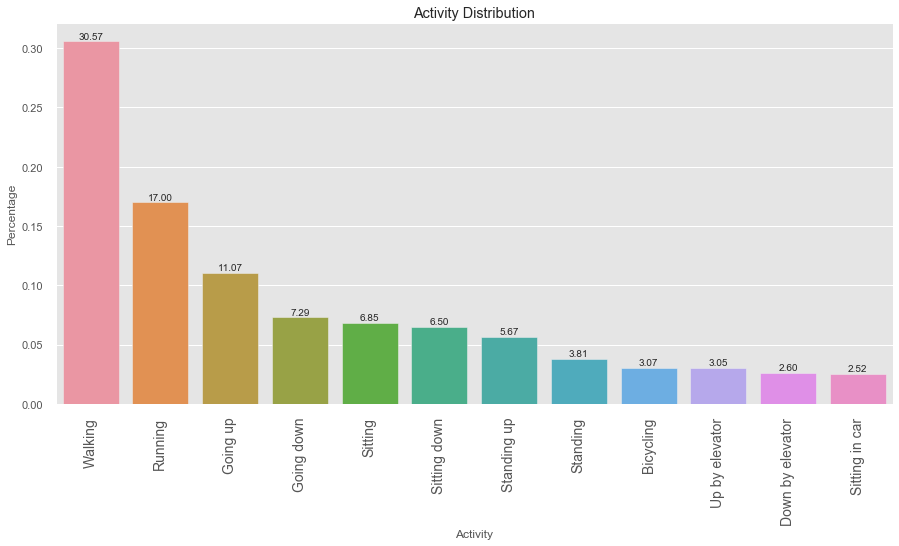

In [35]:
plt.figure(figsize=(15,7))
yaxis = grouped_hugadb['activity'].value_counts().values / grouped_hugadb.shape[0]
labels = ['Walking', 'Running', 'Going up', 'Going down', 'Sitting', 'Sitting down', 'Standing up', 'Standing', 'Bicycling', 'Up by elevator', 'Down by elevator', 'Sitting in car']
barplot = sns.barplot(x = labels, y=yaxis)
for p in barplot.patches:
    barplot.annotate(format(p.get_height()*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.xticks(fontsize=14)
plt.xticks(rotation='vertical')
plt.title("Activity Distribution")
plt.xlabel('Activity')
plt.ylabel('Percentage')

# Classical Machine Learning Models

In [36]:
grouped_hugadb[grouped_hugadb.isnull().any(axis=1)]

,act,acc_rf_x_min,acc_rf_x_max,acc_rf_x_mean,acc_rf_x_std,acc_rf_x_range,acc_rf_y_min,acc_rf_y_max,acc_rf_y_mean,acc_rf_y_std,...,acc_rf_z_max,acc_rf_z_mean,acc_rf_z_std,acc_rf_z_range,acc_norm_min,acc_norm_max,acc_norm_mean,acc_norm_std,acc_norm_range,activity
207,1,-32768,-32768,-32768.0,nan,0,-4832,-4832,-4832.0,nan,...,12984,12984.0,nan,0,35576.3,35576.3,35576.3,nan,0.0,Walking
536,1,-15516,-15516,-15516.0,nan,0,3712,3712,3712.0,nan,...,-3296,-3296.0,nan,0,16290.8,16290.8,16290.8,nan,0.0,Walking
1206,1,-7444,-7444,-7444.0,nan,0,-10468,-10468,-10468.0,nan,...,14292,14292.0,nan,0,19216.0,19216.0,19216.0,nan,0.0,Walking
1400,1,-16584,-16584,-16584.0,nan,0,-32768,-32768,-32768.0,nan,...,25804,25804.0,nan,0,44884.5,44884.5,44884.5,nan,0.0,Walking
1856,1,-11768,-11768,-11768.0,nan,0,-1604,-1604,-1604.0,nan,...,3904,3904.0,nan,0,12502.0,12502.0,12502.0,nan,0.0,Walking
2318,1,-13696,-13696,-13696.0,nan,0,-4024,-4024,-4024.0,nan,...,-3016,-3016.0,nan,0,14590.0,14590.0,14590.0,nan,0.0,Walking
2331,1,32767,32767,32767.0,nan,0,-6304,-6304,-6304.0,nan,...,2460,2460.0,nan,0,33458.5,33458.5,33458.5,nan,0.0,Walking
2446,1,-10628,-10628,-10628.0,nan,0,-7028,-7028,-7028.0,nan,...,9948,9948.0,nan,0,16165.1,16165.1,16165.1,nan,0.0,Walking
2459,1,9216,9216,9216.0,nan,0,672,672,672.0,nan,...,15872,15872.0,nan,0,18365.9,18365.9,18365.9,nan,0.0,Walking
5740,3,-17220,-17220,-17220.0,nan,0,-396,-396,-396.0,nan,...,-11248,-11248.0,nan,0,20571.9,20571.9,20571.9,nan,0.0,Going up


In [37]:
grouped_hugadb = clean_dataset(grouped_hugadb)
grouped_hugadb

,act,acc_rf_x_min,acc_rf_x_max,acc_rf_x_mean,acc_rf_x_std,acc_rf_x_range,acc_rf_y_min,acc_rf_y_max,acc_rf_y_mean,acc_rf_y_std,...,acc_rf_z_max,acc_rf_z_mean,acc_rf_z_std,acc_rf_z_range,acc_norm_min,acc_norm_max,acc_norm_mean,acc_norm_std,acc_norm_range,activity
0,1,-32768,15656,-15436.7,11323.9,48424,-27832,19024,-2951.4,9017.1,...,32767,13153.1,11307.1,65535,16009.9,51644.4,26088.6,8527.0,35634.5,Walking
1,1,-32768,11160,-11995.5,10121.5,43928,-29140,20056,-4461.0,6273.2,...,32767,14315.4,7175.0,43575,11183.2,45744.6,22544.9,7250.6,34561.4,Walking
2,1,-10028,-4944,-7105.3,2626.1,5084,-5624,-4088,-4816.0,771.1,...,23588,20789.3,2957.0,5892,20746.6,24881.1,22667.3,2082.8,4134.5,Walking
3,1,-32768,25412,-13151.7,12640.0,58180,-32768,32767,-10325.1,9923.5,...,32767,14107.4,9489.8,54919,14937.9,56125.1,26768.4,10439.8,41187.2,Walking
4,1,-32768,11792,-13703.6,11865.8,44560,-32768,19616,-8637.5,9849.0,...,32767,13267.6,9903.3,50895,13689.9,56755.3,25869.2,10186.5,43065.4,Walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16009,12,-4096,-40,-2556.5,823.7,4056,-12120,-7040,-9669.4,898.4,...,15024,13438.5,564.7,2880,15301.3,18387.3,16792.1,669.3,3086.1,Sitting in car
16010,12,-4020,-1728,-2878.0,460.2,2292,-12080,-7576,-9661.3,799.4,...,14944,13448.0,557.2,3076,15268.4,18504.1,16828.3,662.0,3235.7,Sitting in car
16011,12,-3284,-1744,-2649.4,325.5,1540,-11000,-9088,-9913.1,333.7,...,14424,13303.9,322.1,1916,16014.5,17643.2,16808.1,300.4,1628.7,Sitting in car
16012,12,-2464,264,-1345.1,594.6,2728,-10712,-9320,-10074.5,268.2,...,13860,13200.9,280.7,1380,16225.0,17227.2,16674.5,178.4,1002.2,Sitting in car


In [38]:
X = grouped_hugadb[grouped_hugadb.columns[1:21]]
X

,acc_rf_x_min,acc_rf_x_max,acc_rf_x_mean,acc_rf_x_std,acc_rf_x_range,acc_rf_y_min,acc_rf_y_max,acc_rf_y_mean,acc_rf_y_std,acc_rf_y_range,acc_rf_z_min,acc_rf_z_max,acc_rf_z_mean,acc_rf_z_std,acc_rf_z_range,acc_norm_min,acc_norm_max,acc_norm_mean,acc_norm_std,acc_norm_range
0,-32768,15656,-15436.7,11323.9,48424,-27832,19024,-2951.4,9017.1,46856,-32768,32767,13153.1,11307.1,65535,16009.9,51644.4,26088.6,8527.0,35634.5
1,-32768,11160,-11995.5,10121.5,43928,-29140,20056,-4461.0,6273.2,49196,-10808,32767,14315.4,7175.0,43575,11183.2,45744.6,22544.9,7250.6,34561.4
2,-10028,-4944,-7105.3,2626.1,5084,-5624,-4088,-4816.0,771.1,1536,17696,23588,20789.3,2957.0,5892,20746.6,24881.1,22667.3,2082.8,4134.5
3,-32768,25412,-13151.7,12640.0,58180,-32768,32767,-10325.1,9923.5,65535,-22152,32767,14107.4,9489.8,54919,14937.9,56125.1,26768.4,10439.8,41187.2
4,-32768,11792,-13703.6,11865.8,44560,-32768,19616,-8637.5,9849.0,52384,-18128,32767,13267.6,9903.3,50895,13689.9,56755.3,25869.2,10186.5,43065.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16009,-4096,-40,-2556.5,823.7,4056,-12120,-7040,-9669.4,898.4,5080,12144,15024,13438.5,564.7,2880,15301.3,18387.3,16792.1,669.3,3086.1
16010,-4020,-1728,-2878.0,460.2,2292,-12080,-7576,-9661.3,799.4,4504,11868,14944,13448.0,557.2,3076,15268.4,18504.1,16828.3,662.0,3235.7
16011,-3284,-1744,-2649.4,325.5,1540,-11000,-9088,-9913.1,333.7,1912,12508,14424,13303.9,322.1,1916,16014.5,17643.2,16808.1,300.4,1628.7
16012,-2464,264,-1345.1,594.6,2728,-10712,-9320,-10074.5,268.2,1392,12480,13860,13200.9,280.7,1380,16225.0,17227.2,16674.5,178.4,1002.2


In [39]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
X_scaled

,acc_rf_x_min,acc_rf_x_max,acc_rf_x_mean,acc_rf_x_std,acc_rf_x_range,acc_rf_y_min,acc_rf_y_max,acc_rf_y_mean,acc_rf_y_std,acc_rf_y_range,acc_rf_z_min,acc_rf_z_max,acc_rf_z_mean,acc_rf_z_std,acc_rf_z_range,acc_norm_min,acc_norm_max,acc_norm_mean,acc_norm_std,acc_norm_range
0,-1.0,0.6,-1.1,1.0,0.8,-0.8,0.5,0.5,0.8,0.7,-1.5,1.0,0.3,1.2,1.5,0.6,1.0,0.9,0.7,0.7
1,-1.0,0.3,-0.2,0.8,0.6,-0.9,0.6,0.1,0.3,0.8,-0.3,1.0,0.5,0.4,0.6,-0.3,0.6,0.4,0.4,0.6
2,0.9,-0.7,0.9,-0.5,-0.8,0.9,-0.9,0.1,-0.8,-0.9,1.2,0.2,1.9,-0.4,-0.8,1.4,-0.6,0.4,-0.6,-0.9
3,-1.0,1.2,-0.5,1.3,1.2,-1.2,1.4,-1.3,1.0,1.4,-1.0,1.0,0.5,0.8,1.1,0.4,1.2,1.1,1.1,0.9
4,-1.0,0.4,-0.6,1.1,0.7,-1.2,0.6,-0.9,1.0,0.9,-0.7,1.0,0.3,0.9,0.9,0.2,1.3,0.9,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15973,1.4,-0.4,2.0,-0.9,-0.9,0.4,-1.1,-1.2,-0.8,-0.8,0.9,-0.6,0.4,-0.8,-0.9,0.5,-0.9,-0.6,-0.9,-0.9
15974,1.4,-0.5,1.9,-0.9,-0.9,0.4,-1.1,-1.2,-0.8,-0.8,0.9,-0.7,0.4,-0.8,-0.9,0.4,-0.9,-0.6,-0.9,-0.9
15975,1.5,-0.5,2.0,-1.0,-1.0,0.5,-1.2,-1.2,-0.9,-0.9,1.0,-0.7,0.3,-0.9,-0.9,0.6,-1.0,-0.6,-1.0,-1.0
15976,1.6,-0.3,2.3,-0.9,-0.9,0.5,-1.2,-1.3,-0.9,-1.0,0.9,-0.8,0.3,-0.9,-0.9,0.6,-1.0,-0.6,-1.0,-1.0


## Data Visualization

In [40]:
X_scaled_viz = X_scaled
X_scaled_viz['activity'] = grouped_hugadb['activity']
X_scaled_viz

,acc_rf_x_min,acc_rf_x_max,acc_rf_x_mean,acc_rf_x_std,acc_rf_x_range,acc_rf_y_min,acc_rf_y_max,acc_rf_y_mean,acc_rf_y_std,acc_rf_y_range,...,acc_rf_z_max,acc_rf_z_mean,acc_rf_z_std,acc_rf_z_range,acc_norm_min,acc_norm_max,acc_norm_mean,acc_norm_std,acc_norm_range,activity
0,-1.0,0.6,-1.1,1.0,0.8,-0.8,0.5,0.5,0.8,0.7,...,1.0,0.3,1.2,1.5,0.6,1.0,0.9,0.7,0.7,Walking
1,-1.0,0.3,-0.2,0.8,0.6,-0.9,0.6,0.1,0.3,0.8,...,1.0,0.5,0.4,0.6,-0.3,0.6,0.4,0.4,0.6,Walking
2,0.9,-0.7,0.9,-0.5,-0.8,0.9,-0.9,0.1,-0.8,-0.9,...,0.2,1.9,-0.4,-0.8,1.4,-0.6,0.4,-0.6,-0.9,Walking
3,-1.0,1.2,-0.5,1.3,1.2,-1.2,1.4,-1.3,1.0,1.4,...,1.0,0.5,0.8,1.1,0.4,1.2,1.1,1.1,0.9,Walking
4,-1.0,0.4,-0.6,1.1,0.7,-1.2,0.6,-0.9,1.0,0.9,...,1.0,0.3,0.9,0.9,0.2,1.3,0.9,1.0,1.0,Walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15973,1.4,-0.4,2.0,-0.9,-0.9,0.4,-1.1,-1.2,-0.8,-0.8,...,-0.6,0.4,-0.8,-0.9,0.5,-0.9,-0.6,-0.9,-0.9,Sitting in car
15974,1.4,-0.5,1.9,-0.9,-0.9,0.4,-1.1,-1.2,-0.8,-0.8,...,-0.7,0.4,-0.8,-0.9,0.4,-0.9,-0.6,-0.9,-0.9,Sitting in car
15975,1.5,-0.5,2.0,-1.0,-1.0,0.5,-1.2,-1.2,-0.9,-0.9,...,-0.7,0.3,-0.9,-0.9,0.6,-1.0,-0.6,-1.0,-1.0,Sitting in car
15976,1.6,-0.3,2.3,-0.9,-0.9,0.5,-1.2,-1.3,-0.9,-1.0,...,-0.8,0.3,-0.9,-0.9,0.6,-1.0,-0.6,-1.0,-1.0,Sitting in car


**Visualizations for feature distribution in space**

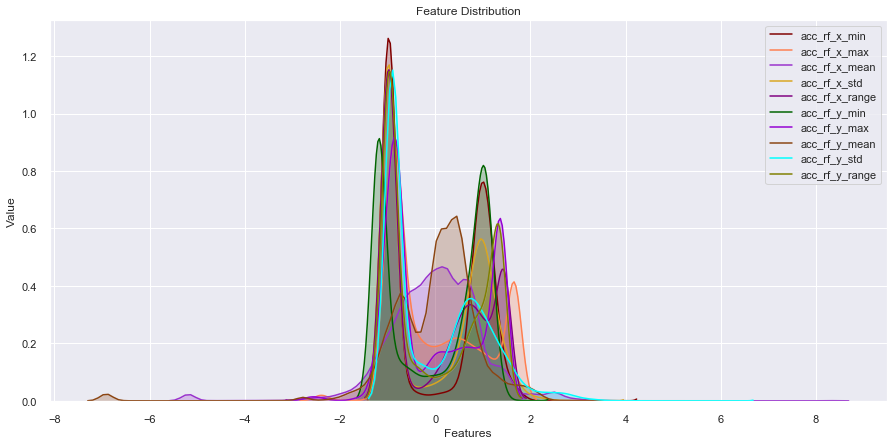

In [41]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in X_scaled_viz.columns[0:10]:
    index = index + 1
    fig = sns.kdeplot(X_scaled_viz[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

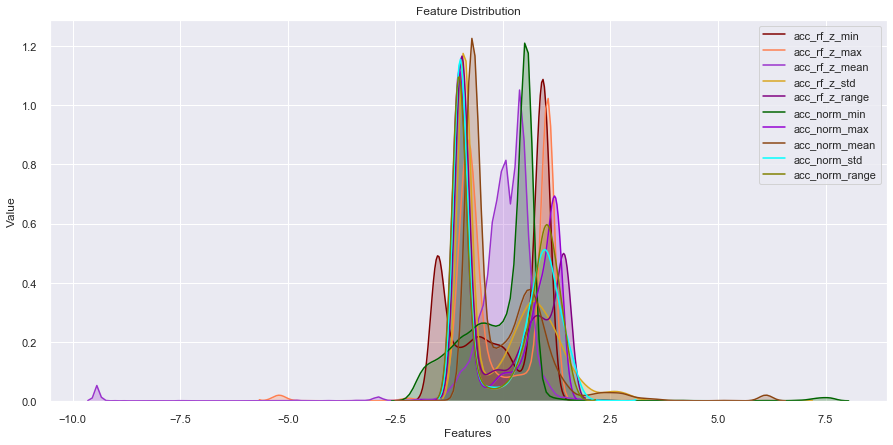

In [42]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in X_scaled_viz.columns[10:20]:
    index = index + 1
    fig = sns.kdeplot(X_scaled_viz[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

**Analysing Static and Dynamic activity by acc_rf_mean feature**

**Static and dynamic activities** :

* *sitting*, *sitting down* , *standing up*, *standing*, *up_by_elevator*, *down_by_elevator* and *sitting in car* can be considered as static activities with no motion involved

* *walking*, *running*, *going_up*, *going_down* and *bicycling* can be considered as dynamic activities with significant amount of motion involved

Text(0.1, 9, 'Dynamic Activities')

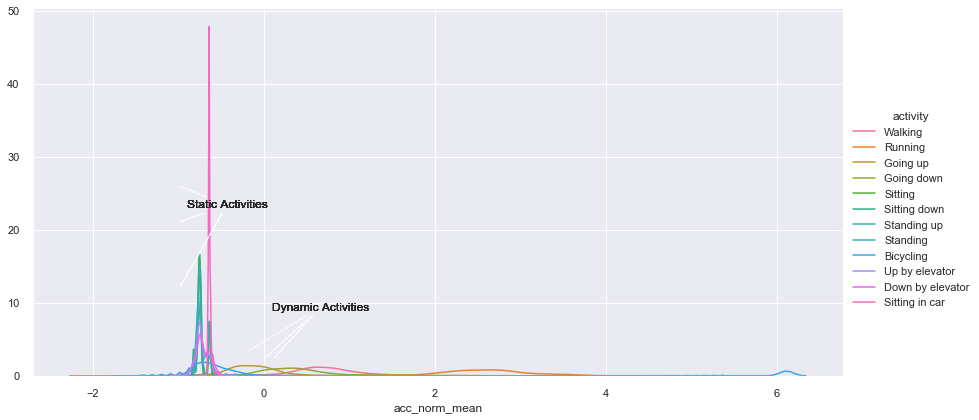

In [43]:
facetgrid = sns.FacetGrid(X_scaled_viz, hue='activity', height=6, aspect=2)
facetgrid.map(sns.distplot,'acc_norm_mean', hist=False).add_legend()
plt.annotate("Static Activities", xy=(-.996,21), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-.999,26), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-0.985,12), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-.996,21), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-.999,26), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-0.985,12), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-0.985,12), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(-0.2,3.25), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(0.1,2.18), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(-0.01,2.15), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(0.1,2.18), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(-0.01,2.15), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})

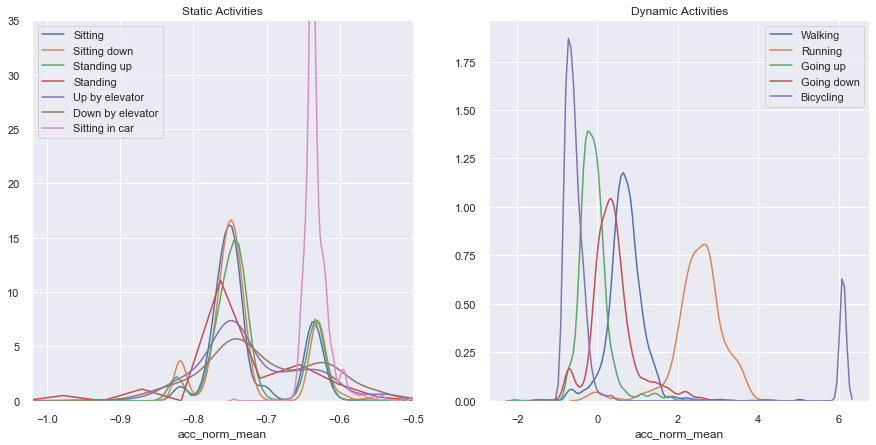

In [44]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Static Activities")
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Sitting"]['acc_norm_mean'],hist = False, label = 'Sitting')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Sitting down"]['acc_norm_mean'],hist = False,label = 'Sitting down')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Standing up"]['acc_norm_mean'],hist = False, label = 'Standing up')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Standing"]['acc_norm_mean'],hist = False, label = 'Standing')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Up by elevator"]['acc_norm_mean'],hist = False,label = 'Up by elevator')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Down by elevator"]['acc_norm_mean'],hist = False, label = 'Down by elevator')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Sitting in car"]['acc_norm_mean'],hist = False, label = 'Sitting in car')
plt.axis([-1.02, -0.5, 0, 35])
plt.subplot(1,2,2)
plt.title("Dynamic Activities")
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Walking"]['acc_norm_mean'],hist = False, label = 'Walking')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Running"]['acc_norm_mean'],hist = False,label = 'Running')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Going up"]['acc_norm_mean'],hist = False, label = 'Going up')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Going down"]['acc_norm_mean'],hist = False,label = 'Going down')
sns.distplot(X_scaled_viz[X_scaled_viz["activity"]=="Bicycling"]['acc_norm_mean'],hist = False, label = 'Bicycling')

**Boxplot activity VS acceleration features**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

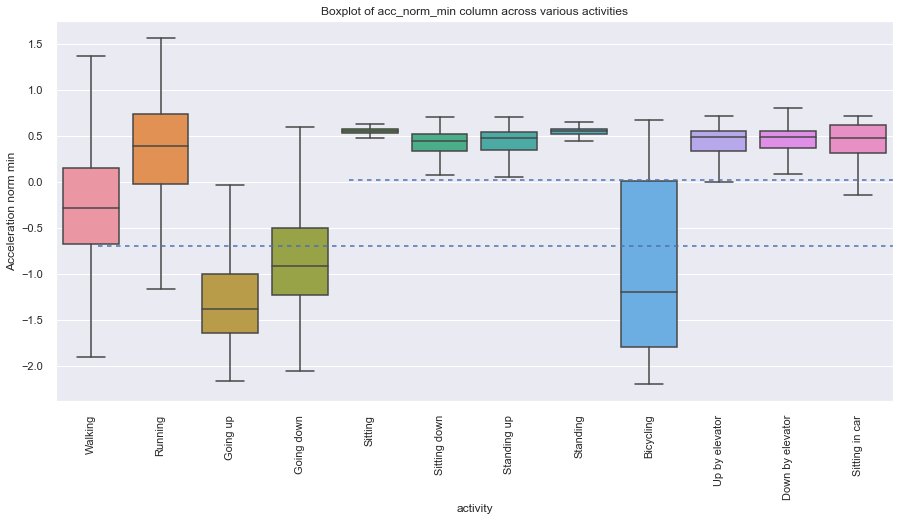

In [45]:
plt.figure(figsize=(15,7))
sns.boxplot(x='activity', y='acc_norm_min',data=X_scaled_viz, showfliers=False)
plt.ylabel('Acceleration norm min')
plt.title("Boxplot of acc_norm_min column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

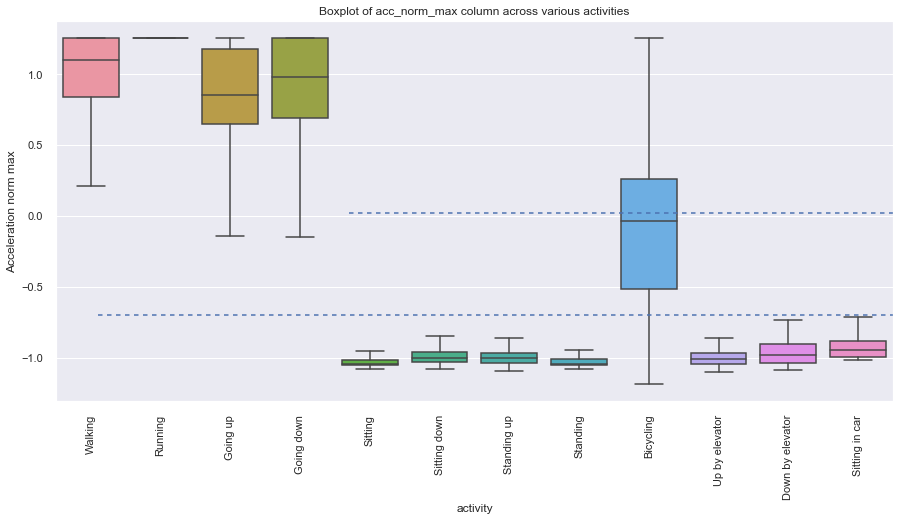

In [46]:
plt.figure(figsize=(15,7))
sns.boxplot(x='activity', y='acc_norm_max',data=X_scaled_viz, showfliers=False)
plt.ylabel('Acceleration norm max')
plt.title("Boxplot of acc_norm_max column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

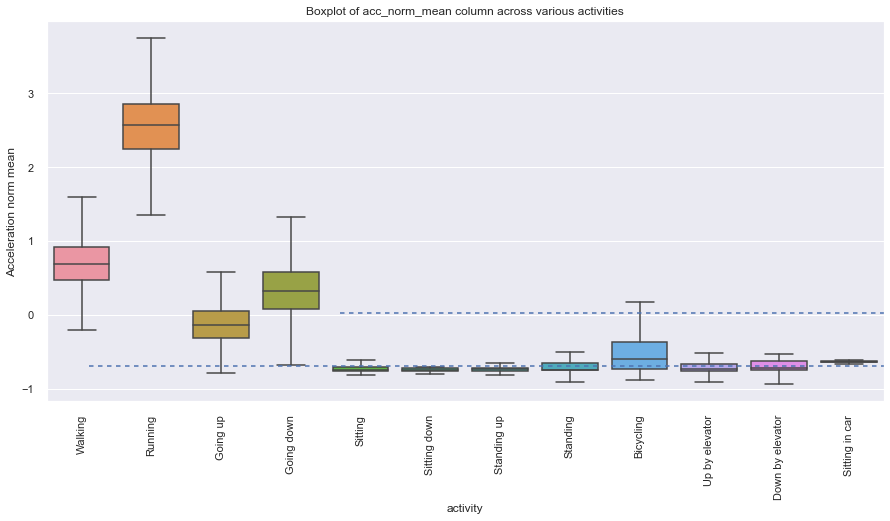

In [47]:
plt.figure(figsize=(15,7))
sns.boxplot(x='activity', y='acc_norm_mean',data=X_scaled_viz, showfliers=False)
plt.ylabel('Acceleration norm mean')
plt.title("Boxplot of acc_norm_mean column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

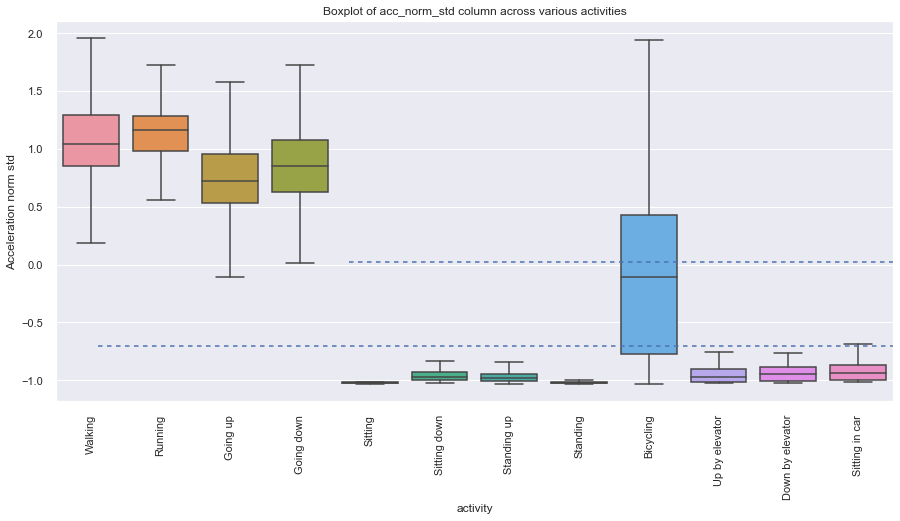

In [48]:
plt.figure(figsize=(15,7))
sns.boxplot(x='activity', y='acc_norm_std',data=X_scaled_viz, showfliers=False)
plt.ylabel('Acceleration norm std')
plt.title("Boxplot of acc_norm_std column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

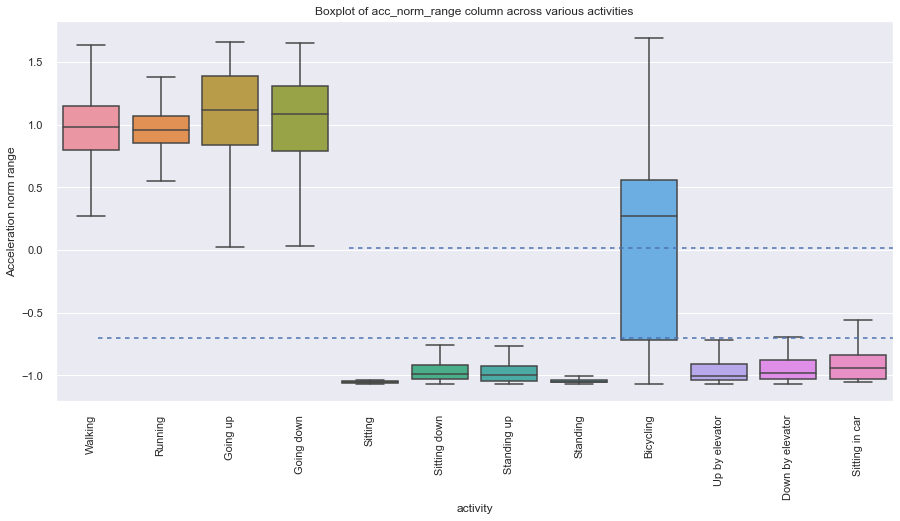

In [49]:
plt.figure(figsize=(15,7))
sns.boxplot(x='activity', y='acc_norm_range',data=X_scaled_viz, showfliers=False)
plt.ylabel('Acceleration norm range')
plt.title("Boxplot of acc_norm_range column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)

**Visualizing data using t-SNE**

In [50]:
del X_scaled['activity']

In [51]:
%time
tsne = TSNE(random_state = 1, n_components=2, verbose=1, perplexity=50, n_iter=1000).fit_transform(X_scaled)

Wall time: 0 ns
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 15978 samples in 0.273s...
[t-SNE] Computed neighbors for 15978 samples in 4.268s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15978
[t-SNE] Computed conditional probabilities for sample 2000 / 15978
[t-SNE] Computed conditional probabilities for sample 3000 / 15978
[t-SNE] Computed conditional probabilities for sample 4000 / 15978
[t-SNE] Computed conditional probabilities for sample 5000 / 15978
[t-SNE] Computed conditional probabilities for sample 6000 / 15978
[t-SNE] Computed conditional probabilities for sample 7000 / 15978
[t-SNE] Computed conditional probabilities for sample 8000 / 15978
[t-SNE] Computed conditional probabilities for sample 9000 / 15978
[t-SNE] Computed conditional probabilities for sample 10000 / 15978
[t-SNE] Computed conditional probabilities for sample 11000 / 15978
[t-SNE] Computed conditional probabilities for sample 12000 / 15978
[t-SNE] Computed conditional prob

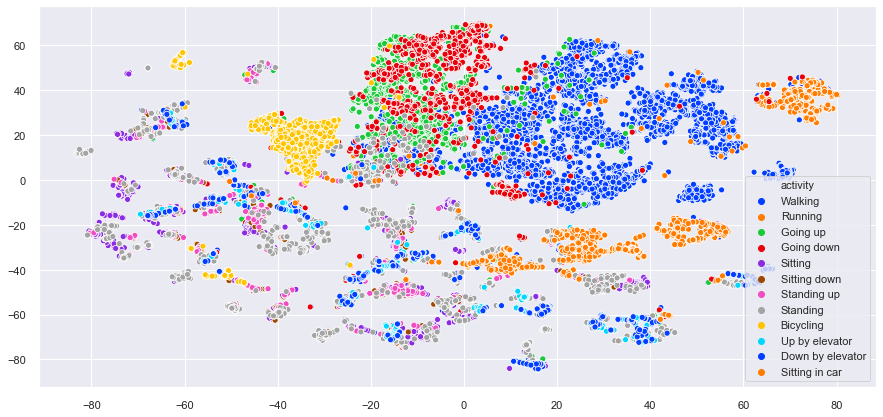

In [52]:
plt.figure(figsize=(15,7))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = grouped_hugadb['activity'],palette="bright")

**Train test split**

In [53]:
grouped_hugadb['act'] = grouped_hugadb['act'].values.astype(np.int64)
y = grouped_hugadb['act']
y.astype('category')

0         1
1         1
2         1
3         1
4         1
         ..
16009    12
16010    12
16011    12
16012    12
16013    12
Name: act, Length: 15978, dtype: category
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]

**Train test split**

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3 , random_state = 1)

## Logistic Regression Classifier

In [55]:
LR_model = LogisticRegression(multi_class='multinomial')
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
LR_model.score(X_train, y_train)

0.693401287553648

In [57]:
LR_model.score(X_val, y_val)

0.696078431372549

In [58]:
y_pred_LR = LR_model.predict(X_val)
LR_score = accuracy_score(y_val, y_pred_LR)

**LR Learning curve**

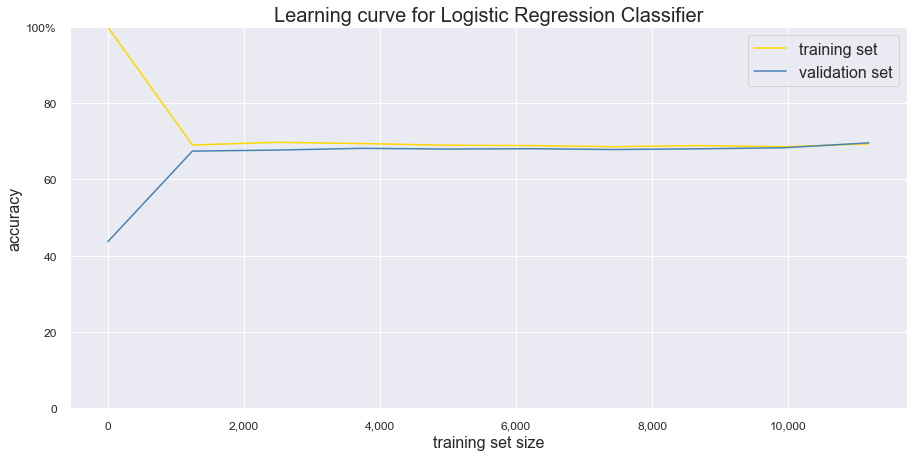

In [59]:
plot_learning_curves(LR_model, X_train, y_train, X_val, y_val, title='Learning curve for Logistic Regression Classifier')

In [60]:
print(classification_report(y_val, y_pred_LR, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.95      0.94      0.94      1487
         Running       0.92      0.93      0.93       136
        Going up       0.79      0.79      0.79       332
      Going down       0.85      0.77      0.81       327
         Sitting       0.53      0.22      0.31       534
    Sitting down       0.08      0.01      0.02       117
     Standing up       0.14      0.01      0.01       131
        Standing       0.41      0.81      0.55       820
       Bicycling       0.92      0.88      0.90       264
  Up by elevator       0.59      0.20      0.30       207
Down by elevator       0.00      0.00      0.00       145
  Sitting in car       0.64      0.81      0.72       294

        accuracy                           0.70      4794
       macro avg       0.57      0.53      0.52      4794
    weighted avg       0.68      0.70      0.66      4794



**LR Confusion matrix**

Confusion matrix without normalization


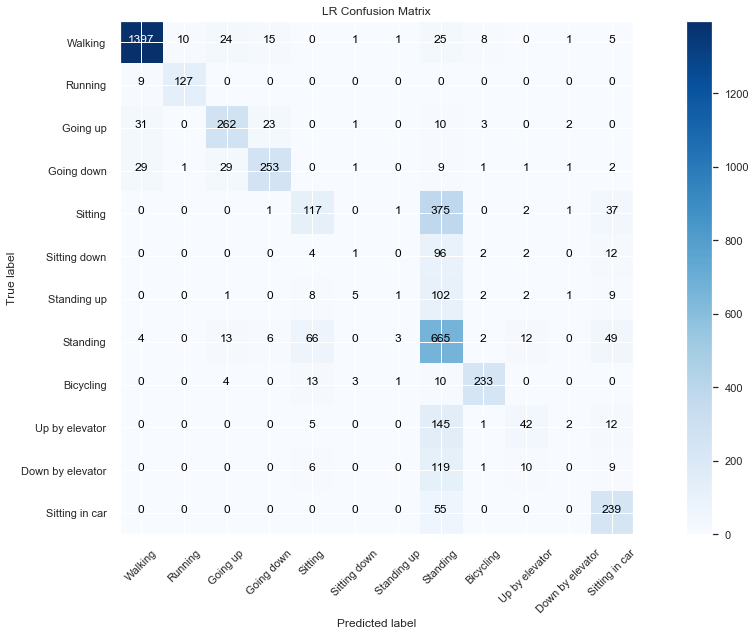

In [61]:
cm = confusion_matrix(y_val, y_pred_LR)
plot_confusion_matrix(cm, classes=labels,
                      title='LR Confusion Matrix')

**LR Feature importance**

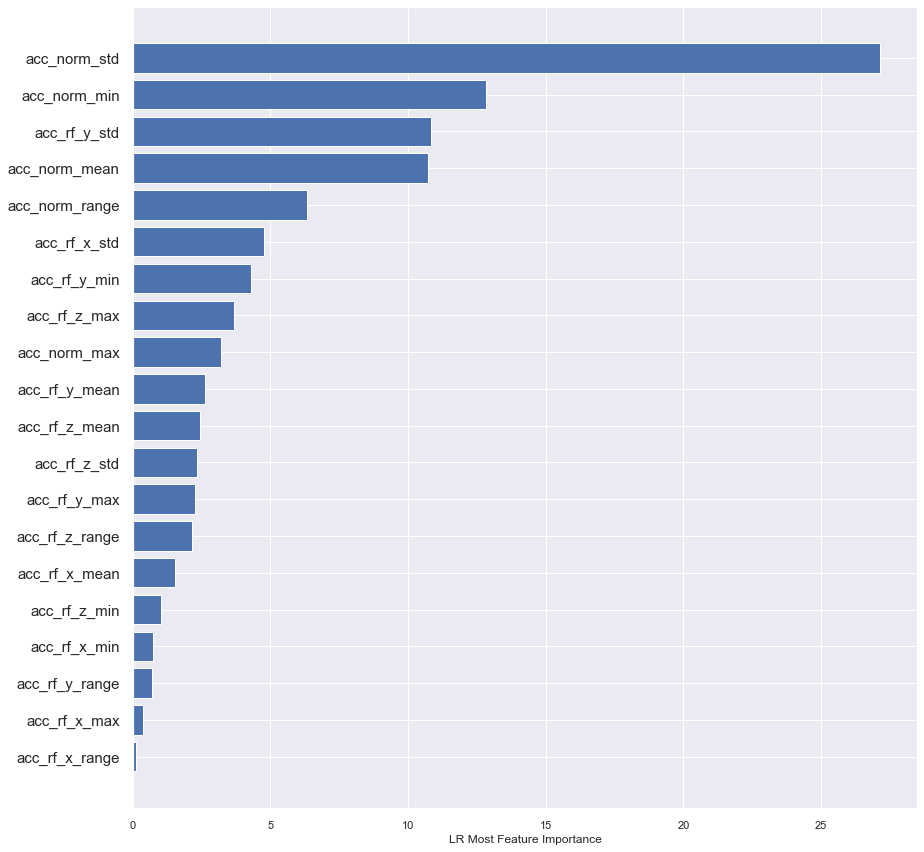

In [62]:
feature_importance = abs(LR_model.coef_[0])
feature_importance = 100.0 * (feature_importance / sum(feature_importance))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(13,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('LR Most Feature Importance')

plt.tight_layout()   
plt.show()

## Decision Tree Classifier

In [63]:
parameters = {'max_depth':np.arange(1,10,1)}
DT_model = DecisionTreeClassifier()
DT_model_rs = RandomizedSearchCV(DT_model,param_distributions=parameters,random_state = 1)
DT_model_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
       

In [64]:
DT_model_rs.best_params_

{'max_depth': 9}

In [65]:
y_pred_DT = DT_model_rs.predict(X_val)
DT_score = accuracy_score(y_val, y_pred_DT)

In [66]:
print(classification_report(y_val, y_pred_DT, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.92      0.93      0.93      1487
         Running       0.94      0.90      0.92       136
        Going up       0.75      0.80      0.77       332
      Going down       0.79      0.66      0.72       327
         Sitting       0.89      0.68      0.77       534
    Sitting down       0.31      0.64      0.42       117
     Standing up       0.00      0.00      0.00       131
        Standing       0.63      0.82      0.71       820
       Bicycling       0.97      0.94      0.95       264
  Up by elevator       0.54      0.22      0.31       207
Down by elevator       0.46      0.42      0.44       145
  Sitting in car       0.85      0.93      0.88       294

        accuracy                           0.78      4794
       macro avg       0.67      0.66      0.65      4794
    weighted avg       0.77      0.78      0.77      4794



**DT Confusion matrix**

Confusion matrix without normalization


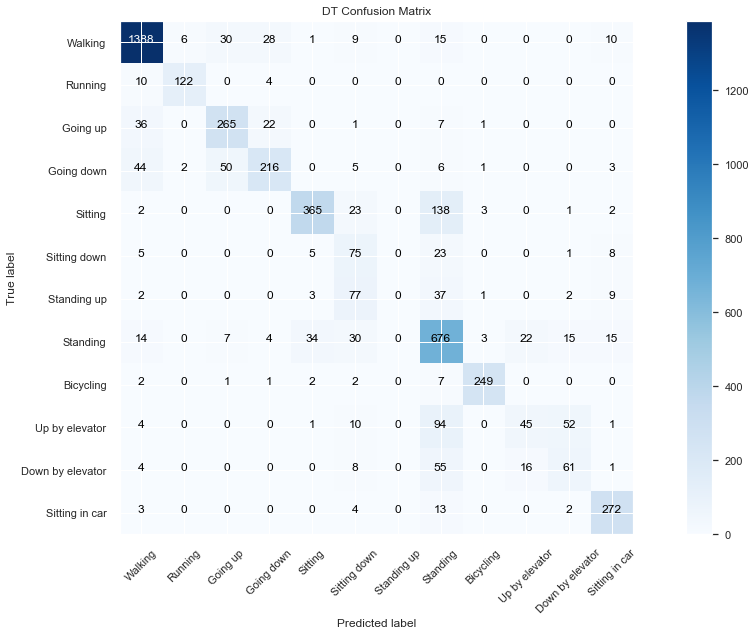

In [67]:
cm = confusion_matrix(y_val, y_pred_DT)
plot_confusion_matrix(cm, classes=labels,
                      title='DT Confusion Matrix')

## Support Vector Classifier

**Hyperparameter tuning using random search CV**

In [68]:
parameters = {'C':[2,4,8,16],'gamma': [0.125, 0.250, 0.5, 1]}
SVM_model = SVC(kernel='rbf')
SVM_model_rs = RandomizedSearchCV(SVM_model,param_distributions=parameters,random_state = 1)
SVM_model_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [2, 4, 8, 16],
                                        'gamma': [0.125, 0.25, 0.5, 1]},
                   pre_dispatch='2*n_jobs', random_state=1, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [69]:
y_pred_SVM = SVM_model_rs.predict(X_val)
SVM_score = accuracy_score(y_val, y_pred_SVM)

In [70]:
print(classification_report(y_val, y_pred_SVM, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.93      0.95      0.94      1487
         Running       0.95      0.91      0.93       136
        Going up       0.85      0.83      0.84       332
      Going down       0.87      0.82      0.84       327
         Sitting       0.63      0.59      0.61       534
    Sitting down       0.46      0.44      0.45       117
     Standing up       0.60      0.33      0.42       131
        Standing       0.56      0.70      0.62       820
       Bicycling       0.98      0.98      0.98       264
  Up by elevator       0.56      0.37      0.44       207
Down by elevator       0.46      0.27      0.34       145
  Sitting in car       0.94      0.98      0.96       294

        accuracy                           0.78      4794
       macro avg       0.73      0.68      0.70      4794
    weighted avg       0.78      0.78      0.77      4794



**SVC Confusion matrix**

Confusion matrix without normalization


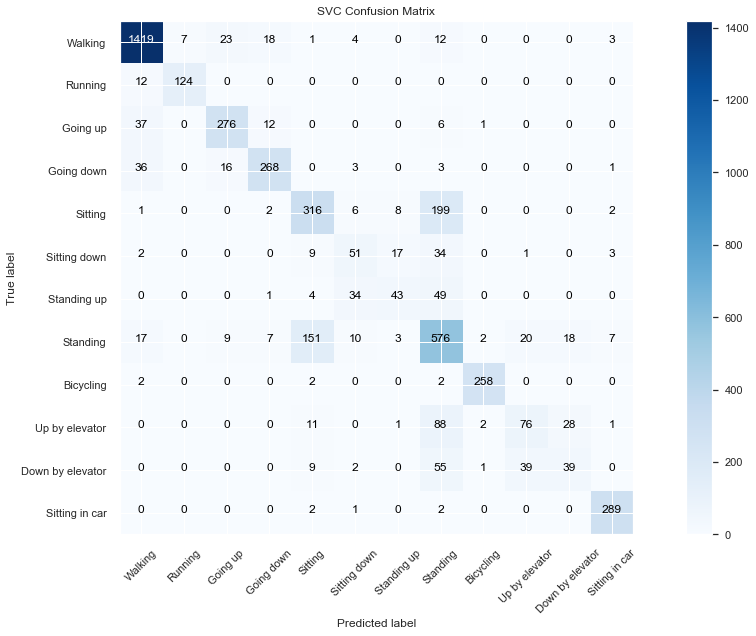

In [71]:
cm = confusion_matrix(y_val, y_pred_SVM)
plot_confusion_matrix(cm, classes=labels,
                      title='SVC Confusion Matrix')

## KNN Classifier

In [72]:
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [73]:
y_pred_KNN = KNN_model.predict(X_val)
KNN_score = accuracy_score(y_val, y_pred_KNN)

**KNN Learning curve**

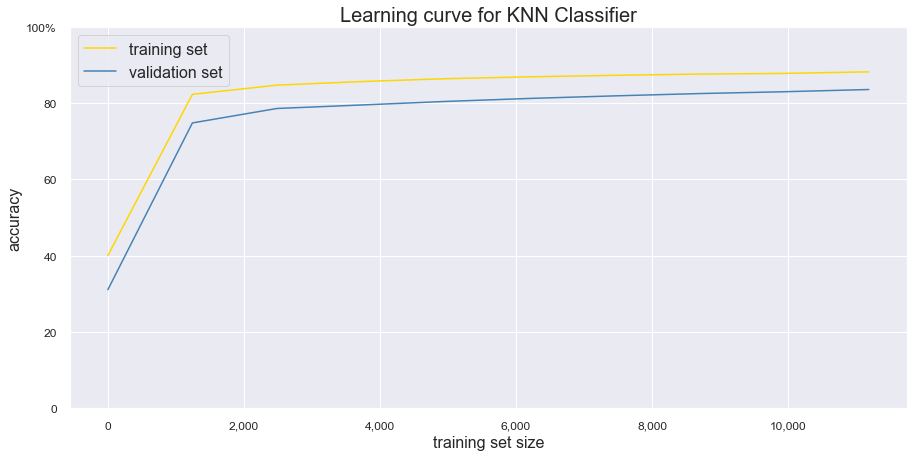

In [74]:
plot_learning_curves(KNN_model, X_train, y_train, X_val, y_val, title='Learning curve for KNN Classifier')

In [75]:
print(classification_report(y_val, y_pred_KNN, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.94      0.95      0.95      1487
         Running       0.95      0.93      0.94       136
        Going up       0.81      0.80      0.81       332
      Going down       0.87      0.80      0.83       327
         Sitting       0.84      0.87      0.86       534
    Sitting down       0.46      0.56      0.50       117
     Standing up       0.56      0.35      0.43       131
        Standing       0.75      0.79      0.77       820
       Bicycling       0.95      0.98      0.96       264
  Up by elevator       0.56      0.55      0.55       207
Down by elevator       0.52      0.41      0.46       145
  Sitting in car       0.93      0.98      0.95       294

        accuracy                           0.84      4794
       macro avg       0.76      0.75      0.75      4794
    weighted avg       0.83      0.84      0.83      4794



**KNN Confusion matrix**

Confusion matrix without normalization


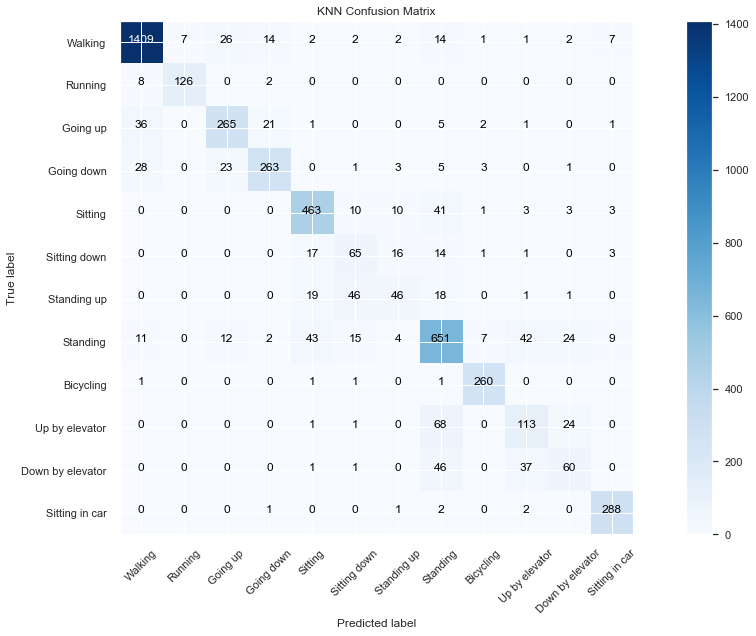

In [76]:
cm = confusion_matrix(y_val, y_pred_KNN)
plot_confusion_matrix(cm, classes=labels,
                      title='KNN Confusion Matrix')

## Random Forest Classifier

**Hyperparameter tuning using random search CV**

In [77]:
params = {'n_estimators': np.arange(20,101,10), 'max_depth':np.arange(2,16,2)}
RF_model = RandomForestClassifier()
RF_model_rs = RandomizedSearchCV(RF_model, param_distributions=params,random_state = 1)
RF_model_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [78]:
y_pred_RF = RF_model_rs.predict(X_val)
RF_score = accuracy_score(y_val, y_pred_RF)

In [79]:
print(classification_report(y_val, y_pred_RF, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.93      0.96      0.94      1487
         Running       0.93      0.94      0.94       136
        Going up       0.84      0.82      0.83       332
      Going down       0.94      0.75      0.83       327
         Sitting       0.91      0.76      0.83       534
    Sitting down       0.45      0.50      0.48       117
     Standing up       0.49      0.33      0.39       131
        Standing       0.69      0.86      0.76       820
       Bicycling       0.97      0.98      0.97       264
  Up by elevator       0.65      0.49      0.56       207
Down by elevator       0.59      0.43      0.50       145
  Sitting in car       0.93      1.00      0.96       294

        accuracy                           0.84      4794
       macro avg       0.78      0.74      0.75      4794
    weighted avg       0.84      0.84      0.83      4794



**RF Confusion matrix**

Confusion matrix without normalization


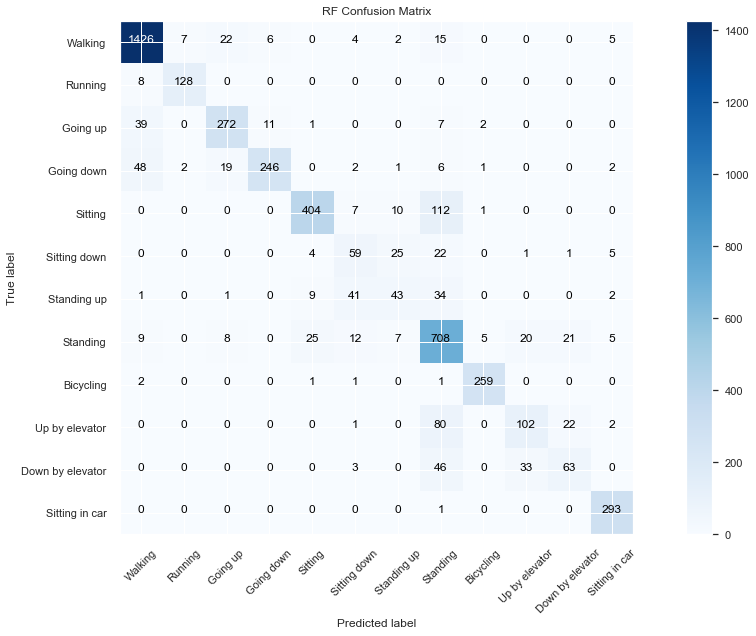

In [80]:
cm = confusion_matrix(y_val, y_pred_RF)
plot_confusion_matrix(cm, classes=labels,
                      title='RF Confusion Matrix')

## LightGBM Classifier

In [81]:
# Create the model
LGBM_model = LGBMClassifier(n_estimators=2000, random_state=1)
LGBM_model = LGBM_model.fit(X_train, y_train)

In [82]:
y_pred_LGBM = LGBM_model.predict(X_val)
LGBM_score = accuracy_score(y_val, y_pred_LGBM)

In [83]:
print(classification_report(y_val, y_pred_LGBM, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.95      0.95      0.95      1487
         Running       0.95      0.92      0.93       136
        Going up       0.87      0.86      0.86       332
      Going down       0.90      0.84      0.87       327
         Sitting       0.92      0.89      0.91       534
    Sitting down       0.50      0.56      0.53       117
     Standing up       0.52      0.46      0.49       131
        Standing       0.77      0.83      0.80       820
       Bicycling       0.97      0.99      0.98       264
  Up by elevator       0.64      0.53      0.58       207
Down by elevator       0.56      0.56      0.56       145
  Sitting in car       0.95      0.99      0.97       294

        accuracy                           0.86      4794
       macro avg       0.79      0.78      0.79      4794
    weighted avg       0.86      0.86      0.86      4794



**LGBM Confusion matrix**

Confusion matrix without normalization


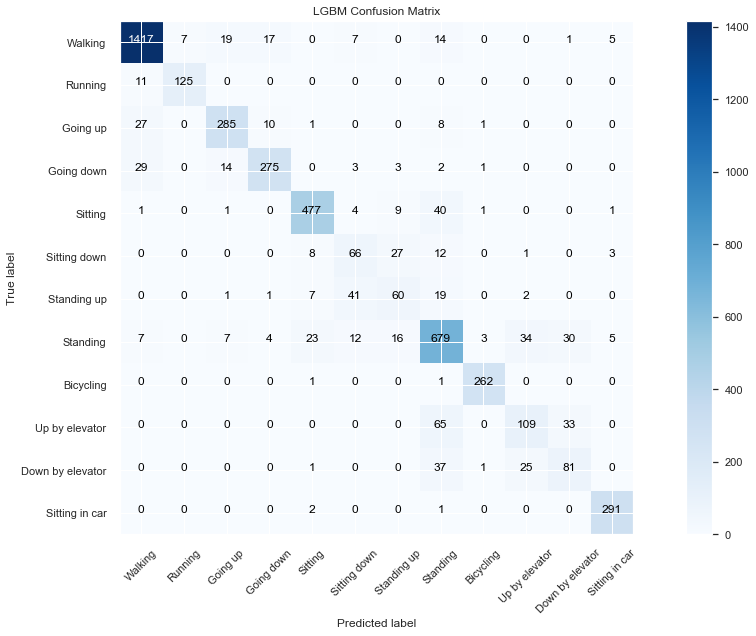

In [84]:
cm = confusion_matrix(y_val, y_pred_LGBM)
plot_confusion_matrix(cm, classes=labels,
                      title='LGBM Confusion Matrix')

**LGBM Feature Importance**

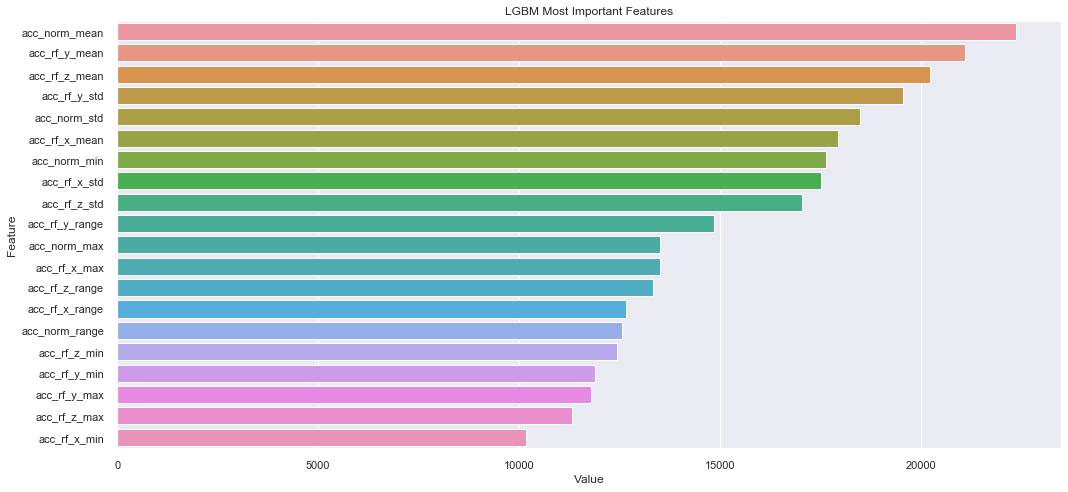

In [85]:
feature_imp = pd.DataFrame(sorted(zip(LGBM_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(15, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBM Most Important Features')
plt.tight_layout()
plt.show()

## XGBoost Classifier

In [86]:
XGBoost_model = xgb.XGBClassifier(n_estimators=2000, random_state=1)  
XGBoost_model = XGBoost_model.fit(X_train, y_train)

In [87]:
y_pred_XGBoost = XGBoost_model.predict(X_val)
XGBoost_score = accuracy_score(y_val, y_pred_XGBoost)

In [88]:
print(classification_report(y_val, y_pred_XGBoost, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.95      0.94      0.95      1487
         Running       0.95      0.94      0.94       136
        Going up       0.84      0.86      0.85       332
      Going down       0.88      0.85      0.87       327
         Sitting       0.91      0.88      0.89       534
    Sitting down       0.46      0.50      0.48       117
     Standing up       0.54      0.45      0.49       131
        Standing       0.77      0.83      0.80       820
       Bicycling       0.97      0.99      0.98       264
  Up by elevator       0.63      0.49      0.55       207
Down by elevator       0.53      0.53      0.53       145
  Sitting in car       0.95      0.99      0.97       294

        accuracy                           0.86      4794
       macro avg       0.78      0.77      0.78      4794
    weighted avg       0.85      0.86      0.85      4794



**XGBoost Confusion matrix**

Confusion matrix without normalization


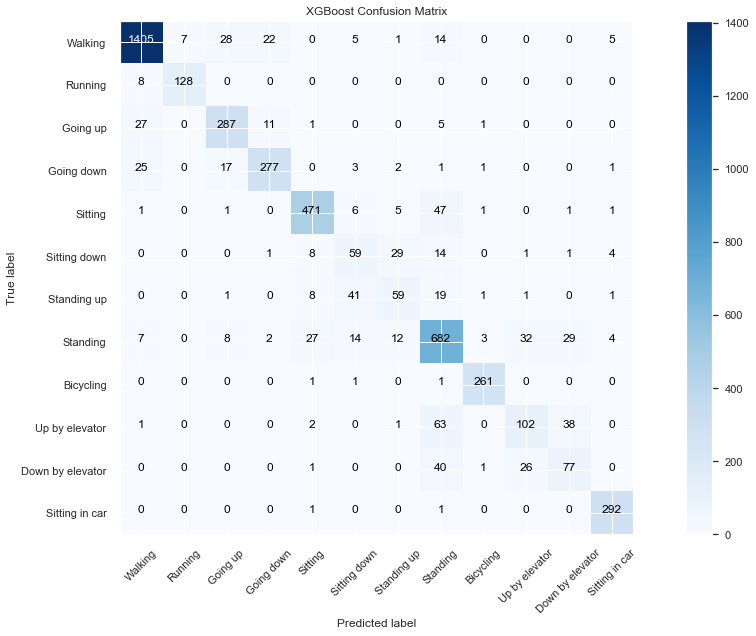

In [89]:
cm = confusion_matrix(y_val, y_pred_XGBoost)
plot_confusion_matrix(cm, classes=labels,
                      title='XGBoost Confusion Matrix')

**XGBoost Feature Importance**

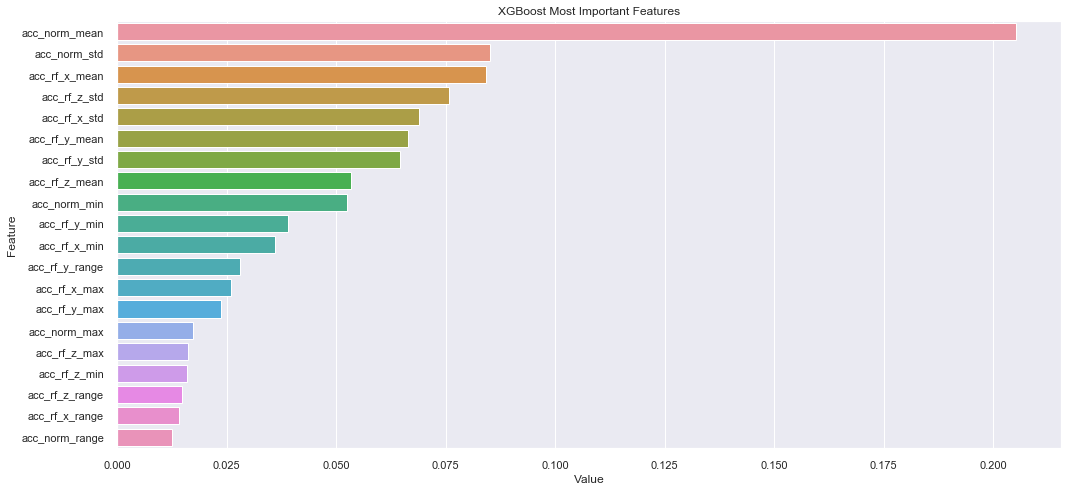

In [90]:
feature_imp = pd.DataFrame(sorted(zip(XGBoost_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(15, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Most Important Features')
plt.tight_layout()
plt.show()

## Artificial Neural Network

In [91]:
y_train_nn = pd.get_dummies(y_train).values
y_val_nn = pd.get_dummies(y_val).values

**Performing Artificial Neural Network following various batch size**

In [92]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_val, y_val, n_batch):
    # define model
    model = Sequential()
    model.add(Dense(units=64,kernel_initializer='uniform',activation='relu',input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=128,kernel_initializer='uniform',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,kernel_initializer='uniform',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=12,kernel_initializer='uniform',activation='softmax'))
    # compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, verbose=0, batch_size=n_batch)
    # plot learning curves
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('batch='+str(n_batch), pad=-40)

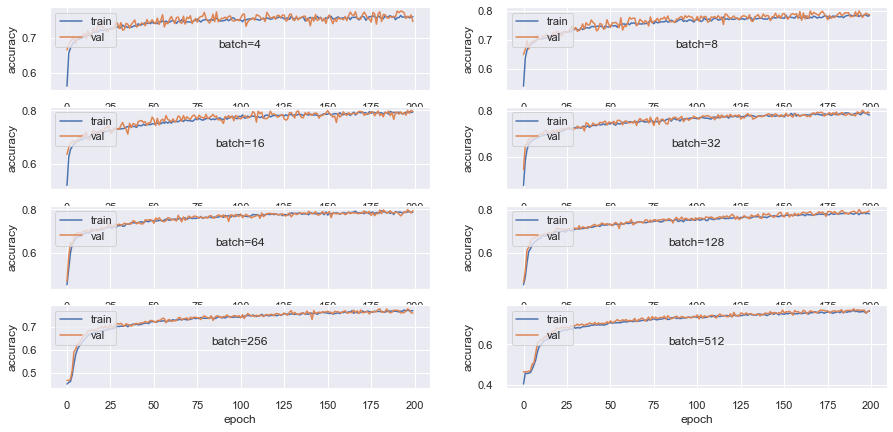

<Figure size 1080x504 with 0 Axes>

In [93]:
# create learning curves for different batch sizes
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
for i in range(len(batch_sizes)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for a batch size
    fit_model(X_train, y_train_nn, X_val, y_val_nn, batch_sizes[i])
# show learning curves
plt.figure(figsize=(15, 7))
plt.show()

**Artificial Neural Network with optimal batch size**

In [94]:
model = Sequential()
model.add(Dense(units=64,kernel_initializer='uniform',activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=128,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=12,kernel_initializer='uniform',activation='softmax'))

In [95]:
# compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                1344      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 12)               

In [97]:
history = model.fit(X_train, y_train_nn, validation_data=(X_val, y_val_nn), epochs=200, batch_size=64)

Train on 11184 samples, validate on 4794 samples
Epoch 1/200
11184/11184 [==============================] - 1s 54us/step - loss: 1.6817 - accuracy: 0.4510 - val_loss: 1.4331 - val_accuracy: 0.5006
Epoch 2/200
11184/11184 [==============================] - 0s 36us/step - loss: 1.2650 - accuracy: 0.5460 - val_loss: 1.0732 - val_accuracy: 0.6160
Epoch 3/200
11184/11184 [==============================] - 0s 36us/step - loss: 1.0857 - accuracy: 0.6132 - val_loss: 0.9921 - val_accuracy: 0.6283
Epoch 4/200
11184/11184 [==============================] - 0s 36us/step - loss: 1.0147 - accuracy: 0.6432 - val_loss: 0.9418 - val_accuracy: 0.6579
Epoch 5/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.9711 - accuracy: 0.6557 - val_loss: 0.9042 - val_accuracy: 0.6796
Epoch 6/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.9361 - accuracy: 0.6651 - val_loss: 0.8820 - val_accuracy: 0.6790
Epoch 7/200
11184/11184 [==============================] - 0s 3

Epoch 56/200
11184/11184 [==============================] - 0s 37us/step - loss: 0.6560 - accuracy: 0.7408 - val_loss: 0.6321 - val_accuracy: 0.7557
Epoch 57/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.6533 - accuracy: 0.7401 - val_loss: 0.6377 - val_accuracy: 0.7543
Epoch 58/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.6563 - accuracy: 0.7440 - val_loss: 0.6323 - val_accuracy: 0.7532
Epoch 59/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.6496 - accuracy: 0.7425 - val_loss: 0.6378 - val_accuracy: 0.7553
Epoch 60/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.6410 - accuracy: 0.7484 - val_loss: 0.6276 - val_accuracy: 0.7545
Epoch 61/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.6346 - accuracy: 0.7493 - val_loss: 0.6261 - val_accuracy: 0.7657
Epoch 62/200
11184/11184 [==============================] - 0s 36us/step - loss: 0.6470 - accuracy: 0.7437

Epoch 111/200
11184/11184 [==============================] - 1s 48us/step - loss: 0.5855 - accuracy: 0.7657 - val_loss: 0.6081 - val_accuracy: 0.7699
Epoch 112/200
11184/11184 [==============================] - 1s 52us/step - loss: 0.5867 - accuracy: 0.7706 - val_loss: 0.5853 - val_accuracy: 0.7843
Epoch 113/200
11184/11184 [==============================] - 1s 50us/step - loss: 0.5751 - accuracy: 0.7730 - val_loss: 0.5898 - val_accuracy: 0.7572
Epoch 114/200
11184/11184 [==============================] - 0s 43us/step - loss: 0.5793 - accuracy: 0.7726 - val_loss: 0.5826 - val_accuracy: 0.7599
Epoch 115/200
11184/11184 [==============================] - 0s 41us/step - loss: 0.5823 - accuracy: 0.7683 - val_loss: 0.5899 - val_accuracy: 0.7841
Epoch 116/200
11184/11184 [==============================] - 0s 42us/step - loss: 0.5812 - accuracy: 0.7701 - val_loss: 0.5969 - val_accuracy: 0.7712
Epoch 117/200
11184/11184 [==============================] - 0s 41us/step - loss: 0.5771 - accuracy:

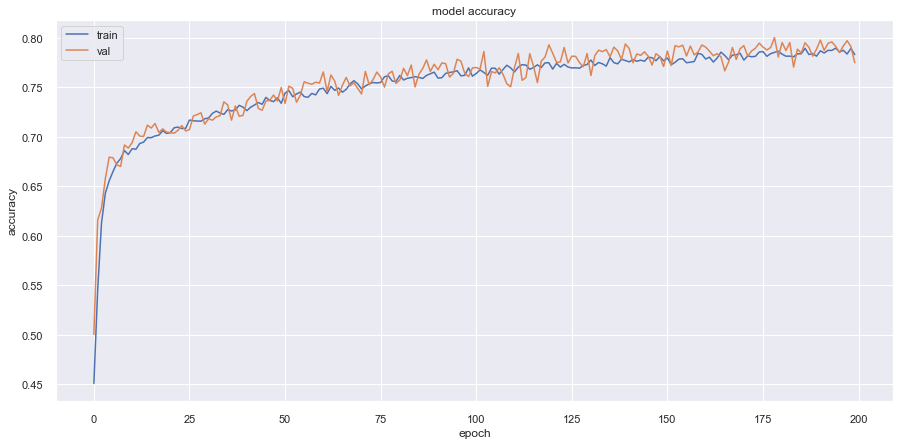

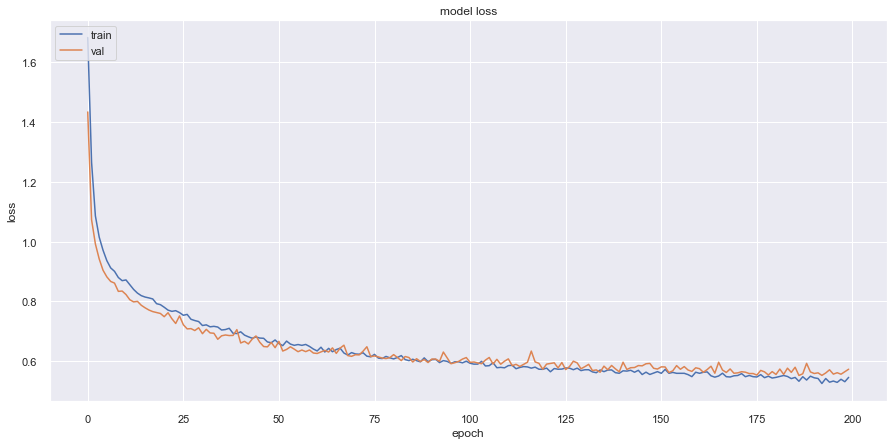

In [98]:
rcParams['figure.figsize'] = 15, 7
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
y_pred_NN = model.predict(X_val)

In [100]:
y_val_class = np.argmax(y_val_nn,axis=1)
y_pred_NN_class = np.argmax(y_pred_NN,axis=1)

In [101]:
NN_score = accuracy_score(y_val_class, y_pred_NN_class)

In [102]:
print(classification_report(y_val_class, y_pred_NN_class, target_names = labels))

                  precision    recall  f1-score   support

         Walking       0.94      0.95      0.95      1487
         Running       0.92      0.93      0.92       136
        Going up       0.86      0.84      0.85       332
      Going down       0.89      0.83      0.86       327
         Sitting       0.67      0.50      0.57       534
    Sitting down       0.40      0.32      0.36       117
     Standing up       0.43      0.34      0.38       131
        Standing       0.55      0.77      0.64       820
       Bicycling       0.96      0.97      0.96       264
  Up by elevator       0.50      0.38      0.43       207
Down by elevator       0.43      0.14      0.21       145
  Sitting in car       0.90      1.00      0.95       294

        accuracy                           0.77      4794
       macro avg       0.70      0.66      0.67      4794
    weighted avg       0.77      0.77      0.77      4794



**Neural Network Confusion matrix**

Confusion matrix without normalization


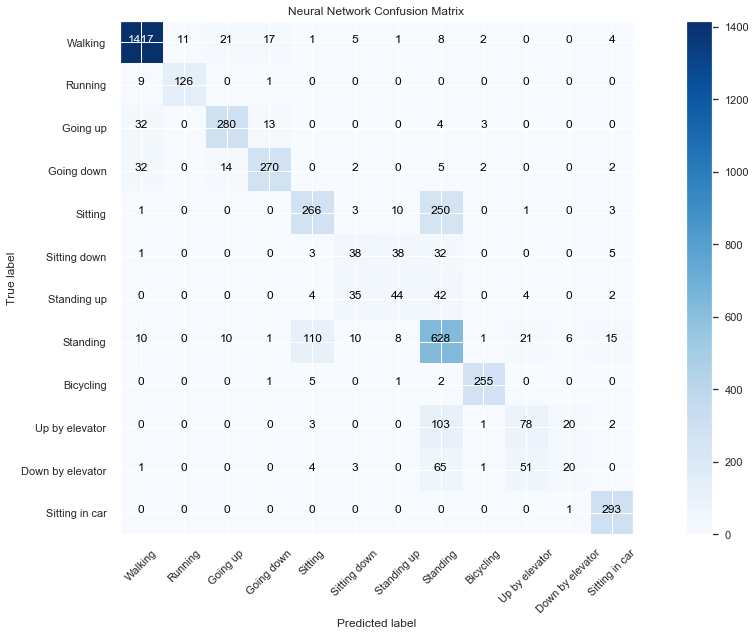

In [103]:
cm = confusion_matrix(y_val_class, y_pred_NN_class)
plot_confusion_matrix(cm, classes=labels,
                      title='Neural Network Confusion Matrix')

## ML Models Accuracy Validation Comparison

In [104]:
ML_score_series = pd.Series([LR_score, DT_score, SVM_score, KNN_score, RF_score, LGBM_score, XGBoost_score, NN_score],
            ['LR_score','DT_score','SVM_score','KNN_score','RF_score', 'XGBoost_score', 'LGBM_score', 'NN_score'])

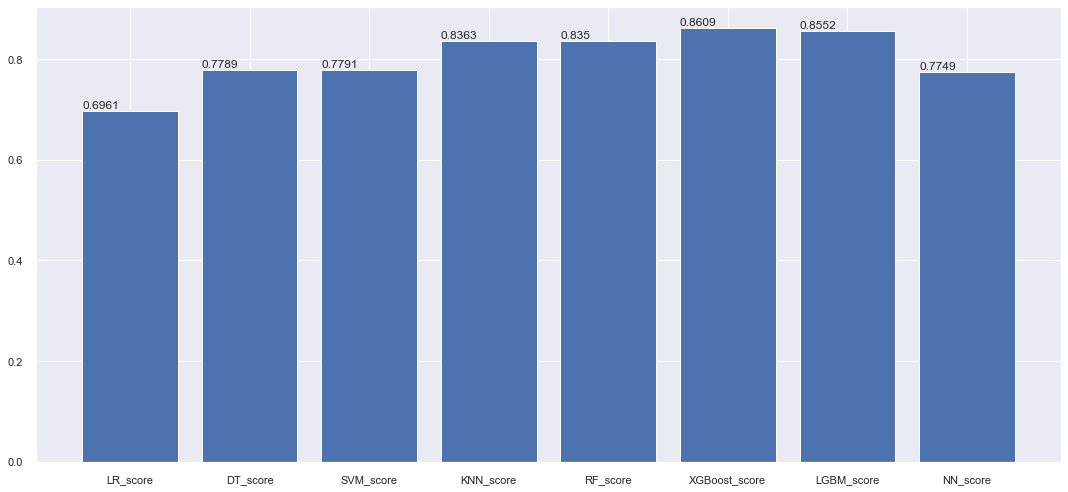

In [105]:
# Comparison of different model accuracy scores
plt.figure(figsize=(15, 7))
bars = plt.bar(ML_score_series.index, ML_score_series.values)
for bar in bars:
    yval = round(bar.get_height(),4)
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()